# 5. Decision trees and random forest

First, we reimport libraries, arrays and list we are going to use for this section (from previous notebook)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('darkgrid')

In [2]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from IPython.display import display

In [3]:
class_labels = [0, 1, 2, 3, 4, 5]
class_names = ['bike', 'car', 'motorcycle', 'other', 'truck', 'van'] 
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

with np.load('train_features.npz') as train_data:
    train_features = train_data['features']
    train_labels = train_data['labels']
    train_images = train_data['images']

X_train = np.array(train_features)
y_train = np.array(train_labels)
images_train = np.array(train_images)


with np.load('valid_features.npz') as valid_data:
    valid_features = valid_data['features']
    valid_labels = valid_data['labels']
    valid_images = valid_data['images']

X_valid = np.array(valid_features)
y_valid = np.array(valid_labels)
images_valid = np.array(valid_images)

with np.load('test_features.npz') as test_data:
    test_features = test_data['features']
    test_labels = test_data['labels']
    test_images = test_data['images']

X_test = np.array(test_features)
y_test = np.array(test_labels)
images_test = np.array(test_images)

We add validation images to train images as we are not using them in GridSearchCV

In [4]:
# Concatenate X_train and X_valid along the first axis
X_train = np.concatenate((X_train, X_valid), axis=0)
y_train = np.concatenate((y_train, y_valid), axis=0)
images_train = np.concatenate((images_train, images_valid), axis=0)

## Depth = 3
What accuracy can you achieve using a decision trees with a depth of 3? Plot the corresponding decision tree with plot_tree()

In [5]:
decision_tree = DecisionTreeClassifier(max_depth=3)

decision_tree.fit(X_train, y_train)

accuracy = decision_tree.score(X_train, y_train)
accuracy_test = decision_tree.score(X_test, y_test)

print("Accuracy of decision tree with depth=3: {:.2f}%".format(accuracy * 100))
print("Accuracy on unseen test data: {:.2f}%".format(accuracy_test * 100))

Accuracy of decision tree with depth=3: 73.99%
Accuracy on unseen test data: 68.00%


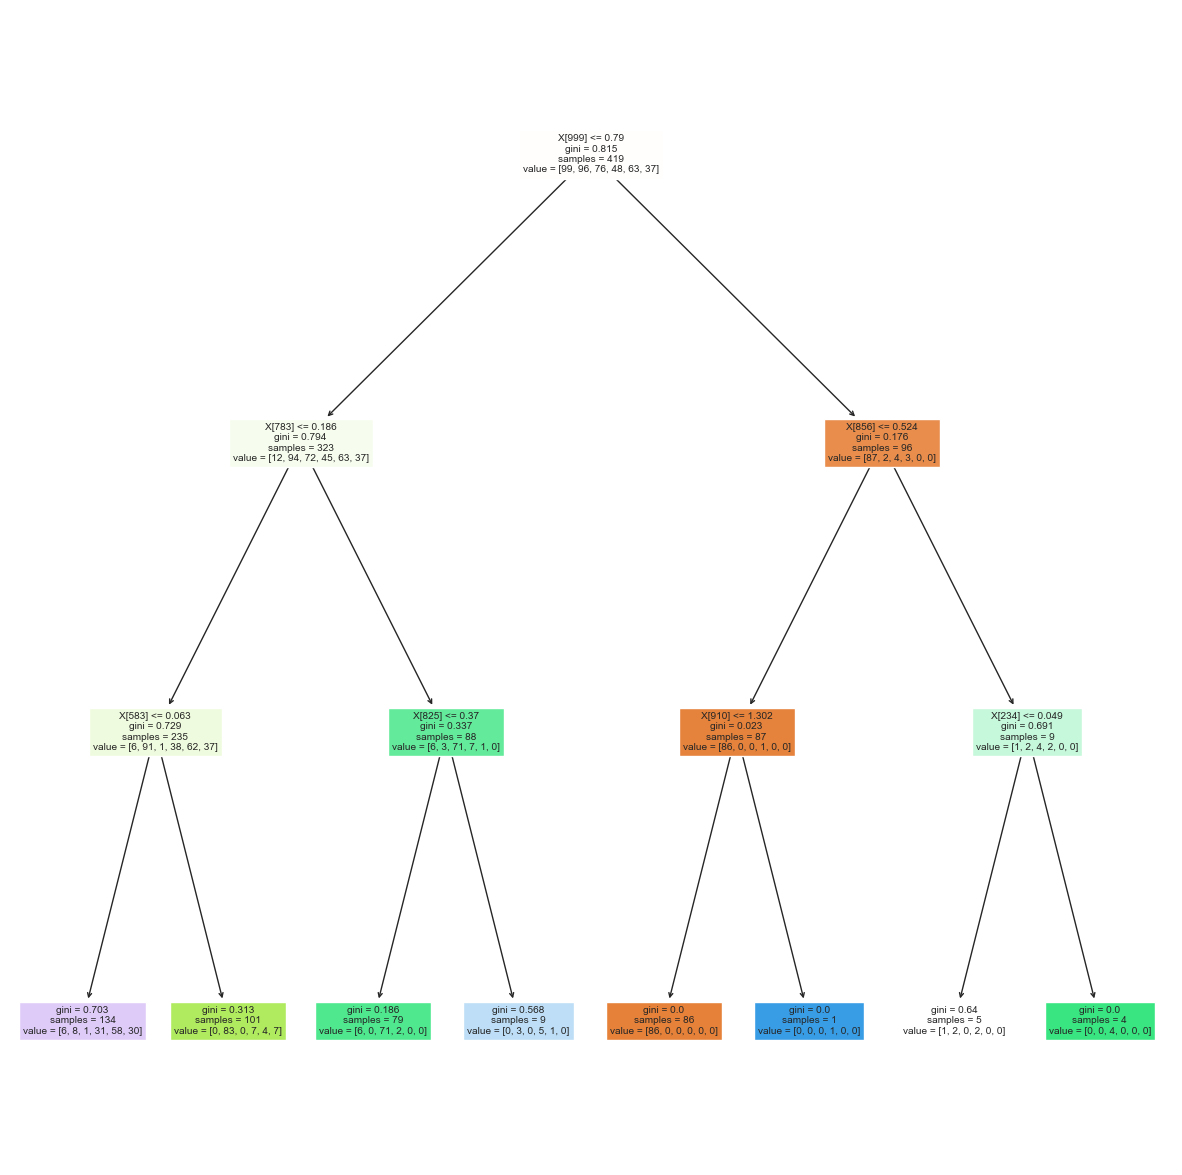

In [6]:
plt.figure(figsize=(15, 15))
plot_tree(decision_tree, filled=True)
plt.show()

## Tune Depth
Tune the depth of your decision tree. Does it improve the accuracy?

In [7]:
decision_tree = DecisionTreeClassifier()

# Try out different depths from 2 to 10
param_grid = {'max_depth': range(2, 11)}

# Use GridSearch to find best parameter
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)
print("Best parameters found by GridSearchCV:", grid_search.best_params_)

# Evaluation on test data
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Accuracy on unseen test data: {:.2f}%".format(test_score * 100))

Best parameters found by GridSearchCV: {'max_depth': 9}
Accuracy on unseen test data: 72.00%


We are able to increase accuracy on unseen test data from 66% to 72%.

## Test PCA + Depth tuning
Do you get better results with your decision tree if you reduce the number of dimensions with PCA first?

We also chose to try out different parameters in param_grid with decision tree, to have fun and find best accuracy possible.
* criterion : default value is 'gini', as the calculation for the impurity coefficient of a leaves. We try out also entropy from documentation

* min_samples_leaf: specifies minimum number of samples required to be at a leaf node. Changing this value might help prevent overfitting as will be harder to isolate samples on training data that can not reproduce on testing.


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Pipeline object that applies PCA.
pca_tree = Pipeline([('pca', PCA()), ('dt', DecisionTreeClassifier())])

# Trying different parameters
param_grid = {'pca__n_components': range(1, 10),
              'dt__criterion': ['gini', 'entropy'],
              'dt__max_depth': range(2, 11),
              'dt__min_samples_leaf': [1, 2, 4]}

# Use GridSearch to find best parameter
grid_search = GridSearchCV(
    estimator=pca_tree,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Best parameters found by GridSearchCV:", grid_search.best_params_)

# Evaluation on test data
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Accuracy on unseen test data:: {:.2f}%".format(test_score * 100))

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best parameters found by GridSearchCV: {'dt__criterion': 'entropy', 'dt__max_depth': 4, 'dt__min_samples_leaf': 1, 'pca__n_components': 3}
Accuracy on unseen test data:: 90.00%


We indeed get a better score with on test data.

Adding grid search results to a dataframe to get detailed view on results from cross-validation.

In [9]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.sort_values("mean_test_score", ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_leaf,param_pca__n_components,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
299,0.021005,0.001789,0.001600,1.200272e-03,entropy,4,1,3,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.892857,...,0.887808,0.012322,1,0.949254,0.934328,0.931343,0.937313,0.940476,0.938543,0.006157
310,0.019604,0.001742,0.001201,3.997330e-04,entropy,4,2,5,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.892857,...,0.885427,0.006089,2,0.946269,0.916418,0.931343,0.931343,0.928571,0.930789,0.009505
317,0.019404,0.001020,0.001201,4.006661e-04,entropy,4,4,3,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.880952,...,0.885399,0.012582,3,0.940299,0.922388,0.919403,0.928358,0.931548,0.928399,0.007329
312,0.021804,0.004308,0.001000,8.341244e-07,entropy,4,2,7,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.880952,...,0.883046,0.009003,4,0.946269,0.916418,0.937313,0.931343,0.928571,0.931983,0.009867
308,0.017405,0.001744,0.001001,2.677941e-06,entropy,4,2,3,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.880952,...,0.883046,0.019092,4,0.946269,0.928358,0.928358,0.931343,0.937500,0.934366,0.006824


## Random forest 
Try a random forest model and tune the number of trees and their depth. Does increasing the number of trees help? Is there an optimal depth and how does it compare to your decision tree above?

In [10]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'pca__n_components': range(1, 5),
              'rf__max_depth': range(4, 8),
              'rf__n_estimators': [50, 75, 100, 125, 150, 175, 200],
              'rf__criterion': ['gini', 'entropy'],
              'rf__min_samples_leaf': [1, 2, 3, 4]}

# RandomForest in pipeline instead of DecisionTree
pca_rf = Pipeline([('pca', PCA()), ('rf', RandomForestClassifier())])

# Use GridSearch to find best parameter
grid_search = GridSearchCV(
    estimator=pca_rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Best parameters found by GridSearchCV:", grid_search.best_params_)

# Evaluation on test data
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Accuracy on unseen test data:: {:.2f}%".format(test_score * 100))

Fitting 5 folds for each of 896 candidates, totalling 4480 fits
Best parameters found by GridSearchCV: {'pca__n_components': 3, 'rf__criterion': 'gini', 'rf__max_depth': 6, 'rf__min_samples_leaf': 4, 'rf__n_estimators': 50}
Accuracy on unseen test data:: 90.00%


We indeed get a better score on test data and we can say that increase number of trees in forest (rf__n_estimators) does not increase accuracy as 50 is our best estimator parameter.

Adding grid search results to a dataframe to get detailed view on results from cross-validation.

In [11]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.sort_values("mean_test_score", ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_rf__criterion,param_rf__max_depth,param_rf__min_samples_leaf,param_rf__n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
525,0.088220,0.000749,0.007002,0.000632,3,gini,6,4,50,"{'pca__n_components': 3, 'rf__criterion': 'gin...",...,0.914114,0.011457,1,0.937313,0.931343,0.925373,0.940299,0.931548,0.933175,0.005191
766,0.212048,0.005623,0.014803,0.000400,4,gini,7,2,125,"{'pca__n_components': 4, 'rf__criterion': 'gin...",...,0.911733,0.014088,2,0.955224,0.952239,0.976119,0.961194,0.949405,0.958836,0.009485
881,0.368883,0.001600,0.023205,0.000400,4,entropy,7,2,200,"{'pca__n_components': 4, 'rf__criterion': 'ent...",...,0.911733,0.014088,2,0.970149,0.973134,0.976119,0.967164,0.967262,0.970766,0.003461
841,0.149634,0.002577,0.009802,0.000400,4,entropy,6,1,75,"{'pca__n_components': 4, 'rf__criterion': 'ent...",...,0.911733,0.014088,2,0.979104,0.973134,0.982090,0.982090,0.976190,0.978522,0.003472
714,0.104725,0.012136,0.009002,0.004518,4,gini,5,3,50,"{'pca__n_components': 4, 'rf__criterion': 'gin...",...,0.911733,0.017659,2,0.943284,0.925373,0.928358,0.943284,0.922619,0.932584,0.008923


### Ranking features
The random forest estimator provides a ranking of the features according to their importance in the classification task via the feature_importances_ attribute. Find the the top 5 important features and visualize their importance scores.

This question does not make real sense if we apply PCA, so we refit the best random forest without PCA in the pipe.

In [12]:
param_grid = {'max_depth': range(4, 8),
              'n_estimators': [50, 75, 100, 125, 150, 175, 200],
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [1, 2, 3, 4]}

# RandomForest without PCA in the pipeline
rf = RandomForestClassifier()

# Use GridSearch to find best parameter
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Best parameters found by GridSearchCV:", grid_search.best_params_)

# Evaluation on test data
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Accuracy on unseen test data: {:.2f}%".format(test_score * 100))

Fitting 5 folds for each of 224 candidates, totalling 1120 fits
Best parameters found by GridSearchCV: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'n_estimators': 175}
Accuracy on unseen test data: 96.00%


Good news we get better accuracy without PCA

In [13]:
# First we refit the best estimator from grid_search
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Feature importance from RandomForest
importances = best_rf.feature_importances_
best_rf.feature_importances_

array([0.0021403 , 0.00024161, 0.00015992, ..., 0.00018866, 0.00235276,
       0.00064362])

In [14]:
# Indices of features from X_train
feature_indices = np.arange(importances.shape[0])

# Sorting by biggest importance
indices = np.argsort(importances)[::-1]

# Getting top 5 features and their importance scores
top_features = feature_indices[indices][:5]
top_importances = importances[indices][:5]

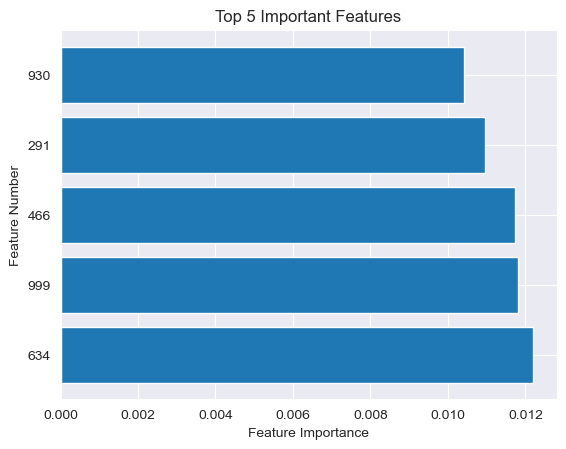

In [15]:
# Converting to string for plot
feature_names = [str(i) for i in top_features]

plt.barh(feature_names, top_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Number")
plt.title("Top 5 Important Features")
plt.show()

### Similarity with logreg
Are these top features similar to the ones you found based on the coefficients in the logistic regression task, and also during the data exploration in the last question of Task 1?

Coefficients from Log regression accross all categories are 
* Index: 323, mean coefficient: 0.254
* Index: 633, mean coefficient: 0.258
* Index: 183, mean coefficient: 0.259
* Index: 580, mean coefficient: 0.265
* Index: 257, mean coefficient: 0.292

So we don't find back the same feature as important in LogReg or in RandomForest